# Pyspark Pipelines

In this notebook, we'll work through building a ML pipeline in Pyspark. The aim of this pipeline will be to make use of a Linear Regression model to predict housing values. We will be making use of Pysparks built-in transformers and estimators for processing our data.

We can start by importing the necessary packages, and setting up our spark session:

In [1]:
import findspark
findspark.init("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec")

In [ ]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline 
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.functions import vector_to_array
spark = SparkSession.builder.appName("pipelines").getOrCreate()

## Dataset

Now let's obtain some data to work with. I'll be making use of the California Housing dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).

In [3]:
# obtain data
data = fetch_california_housing(as_frame=True)
dfX = data["data"]
sY = data["target"]

In [4]:
dfX.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We can generate some plots to aid in exploring these data:

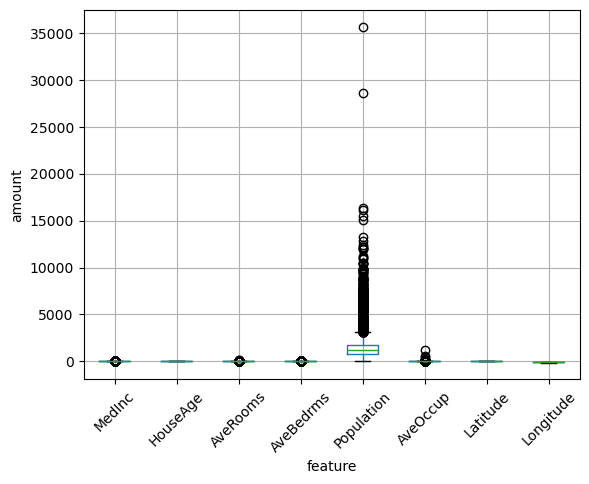

In [5]:
dfX.boxplot(column=dfX.columns.tolist(), rot=45)
plt.xlabel("feature")
plt.ylabel("amount")
plt.show()

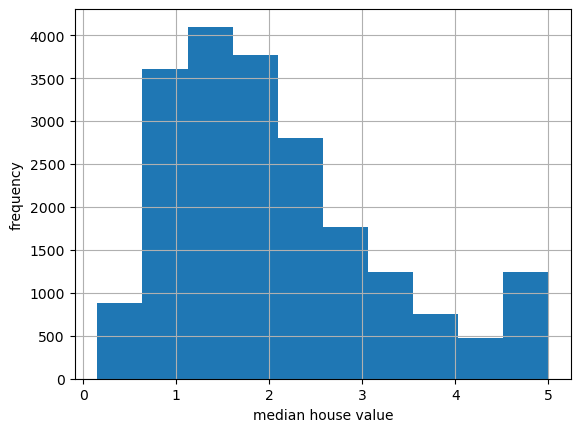

In [6]:
sY.hist()
plt.xlabel("median house value")
plt.ylabel("frequency")
plt.show()

Since I'll be using linear regression to model these data, all of the input features should be standardised. To simplify the example here, I won't consider any treatment of the non-normal appearance of the target label.

Before proceeding, let's place our data into a pyspark dataframe, and perform a train-test split:

In [7]:
# package the data into a pyspark dataframe
dfX["MedianHouseValue"] = sY
df = spark.createDataFrame(dfX)
df.show(5)

+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|MedianHouseValue|
+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23|           4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22|           3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24|           3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25|           3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25|           3.422|
+------+--------+-------

In [8]:
# perform a train-test split
dfTrain, dfTest = df.randomSplit([0.8,0.2])
print(f"Total number of samples in dataset: {df.count()}, training samples: {dfTrain.count()}, testing samples: {dfTest.count()}")

Total number of samples in dataset: 20640, training samples: 16512, testing samples: 4128


## Assembling the Input Features

To start, we'll need to capture all the input features into a single vector column. We can make use of Pyspark's VectorAssembler to accomplish this:

In [9]:
# gather all input features into a single vector column called features
cols = dfTrain.columns[:-1]
assembler = VectorAssembler(inputCols = cols, outputCol="Features")
dfTrain = assembler.transform(dfTrain)
dfTrain.show(5)

+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+--------------------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|MedianHouseValue|            Features|
+------+--------+------------------+------------------+----------+------------------+--------+---------+----------------+--------------------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23|           4.526|[8.3252,41.0,6.98...|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22|           3.585|[8.3014,21.0,6.23...|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24|           3.521|[7.2574,52.0,8.28...|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25|           3.413|[5.6431,52.0,5.81...|

## Standardising the Input Features

We can make use of Pyspark's built-in StandardScaler to transform all the input features to have a mean of 0, and standard deviation of 1. Let's test this out to verify it works: 

In [10]:
# setup the scaler, and train it, and create a new column with our standardised features
scaler = StandardScaler(withMean=True, withStd=True, inputCol="Features", outputCol="StandardFeatures")
model  = scaler.fit(dfTrain)
dfTrain = model.transform(dfTrain)

Let's now plot our results to check the effects of the scaler:

In [11]:
dfPlot = (
    dfTrain
    .select("StandardFeatures")
    .withColumn("Features", vector_to_array("StandardFeatures"))
    .select([F.col("Features")[i] for i in range(len(cols)) ])
    .toPandas()
)

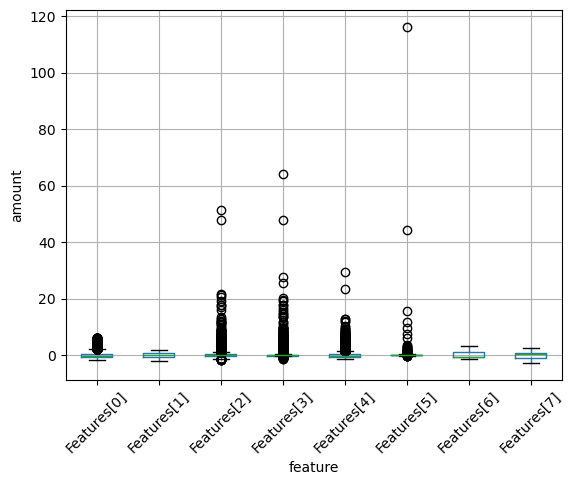

In [12]:
dfPlot.boxplot(column=dfPlot.columns.tolist(), rot=45)
plt.xlabel("feature")
plt.ylabel("amount")
plt.show()

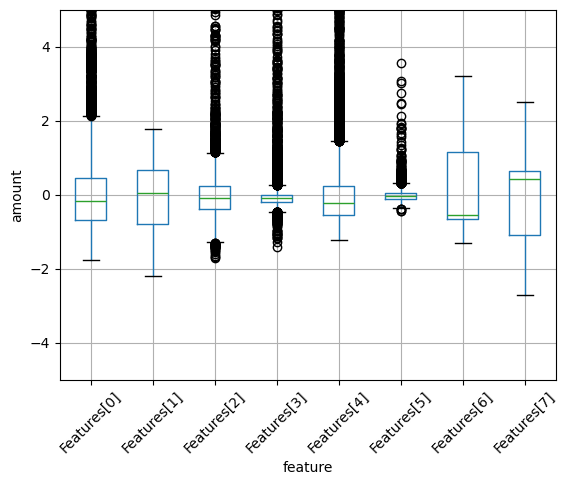

In [13]:
ax = dfPlot.boxplot(column=dfPlot.columns.tolist(), rot=45)
ax.set_ylim(-5, 5)
plt.xlabel("feature")
plt.ylabel("amount")
plt.show()

We can see that the StandardScaler has transformed our data, such that all the features exist at similar scales. It is important to note that differences do persist between the features, however (i.e. number and distribution of outliers, range of quartiles, etc). 

## Linear Regression

Let's now attempt to model our data, using the Linear Regression estimator available in Pyspark: 

In [14]:
# declare a linear regression model, and train it
linear_reg = LinearRegression(featuresCol = 'StandardFeatures', labelCol = 'MedianHouseValue', regParam = 0.01)
model = linear_reg.fit(dfTrain)

24/02/26 21:42:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/02/26 21:42:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [15]:
# make predictions on the training set
dfPred = model.transform(dfTrain)
dfPred.select("MedianHouseValue","prediction").show(5)

+----------------+------------------+
|MedianHouseValue|        prediction|
+----------------+------------------+
|           4.526| 4.105961387706941|
|           3.585|3.9450985896832726|
|           3.521|3.6528152486520455|
|           3.413|3.2131863522892132|
|           3.422|2.3770970949784633|
+----------------+------------------+
only showing top 5 rows



We can see that the model is working: we are able to train it on our data, and use the trained model to generate predictions.

## Putting it All Together

Instead of running the preivous steps separately, we can integrate them all together into a single Pipeline object. Once we have this, we can test out our implementation on the held-out test set. Let's go ahead and do this now:

In [16]:
# regenerate our training and test sets
n_count = df.count()
dfTrain = df.limit(int(n_count*0.8))
dfTest  = df.subtract(dfTrain)

In [17]:
# define the pipeline
cols = dfTrain.columns[:-1]
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols = cols, outputCol="Features"),
    StandardScaler(withMean=True, withStd=True, inputCol="Features", outputCol="StandardFeatures"),
    LinearRegression(featuresCol = 'StandardFeatures', labelCol = 'MedianHouseValue', regParam = 0.01)
])

In [18]:
# train the pipeline
model = pipeline.fit(dfTrain)

In [19]:
# make predictions on the test set
dfPred = model.transform(dfTest)

In [20]:
dfPred.select("MedianHouseValue","prediction").show(5)

+----------------+------------------+
|MedianHouseValue|        prediction|
+----------------+------------------+
|           2.712|2.4989169901008066|
|            2.75|  2.78975161642665|
|         5.00001| 3.574178957899827|
|           1.594|1.8413519603725454|
|         5.00001| 4.504338323735997|
+----------------+------------------+
only showing top 5 rows



In [21]:
n_samples = dfPred.count()
dfPred.select( (1/n_samples * F.sum(F.pow(F.col("MedianHouseValue") - F.col("prediction"),2))).alias("MSE") ).show()

+-----------------+
|              MSE|
+-----------------+
|0.497559083170512|
+-----------------+



It is evident that the pipeline model is working correctly. 

Another nice benefit of pipelines is that we can save our entire workflow, for use at a later time. To save our current pipeline:

In [22]:
# write the trained model to disk
model.write().overwrite().save("./trained_pipeline")

In [23]:
# load the saved model, and confirm it works
model2 = PipelineModel.load("./trained_pipeline")

In [24]:
dfPred = model2.transform(dfTest)
dfPred.select("MedianHouseValue","prediction").show(5)

+----------------+------------------+
|MedianHouseValue|        prediction|
+----------------+------------------+
|           2.712|2.4989169901008066|
|            2.75|  2.78975161642665|
|         5.00001| 3.574178957899827|
|           1.594|1.8413519603725454|
|         5.00001| 4.504338323735997|
+----------------+------------------+
only showing top 5 rows



This result is exactly the same as that obtained earlier above.

In [25]:
spark.stop()